**I) Data Preparation**


**a) Import Yelp data**

In [0]:
import pickle
import pandas as pd

Data from https://www.yelp.com/dataset/documentation/main 

In [0]:
data = pickle.load(open(r'/content/reviews_begin.pickle', "rb" ))

In [0]:
df = pd.DataFrame(data)

**b) Format data and visualize data**

In [0]:
df = df[['stars', 'text']]

In [0]:
df

,stars,text
0,1,Total bill for this horrible service? Over $8G...
1,5,I *adore* Travis at the Hard Rock's new Kelly ...
2,5,I have to say that this office really has it t...
3,5,Went in for a lunch. Steak sandwich was delici...
4,1,Today was my second out of three sessions I ha...
...,...,...
99995,3,I love the clothes in Aritzia. The service I c...
99996,1,We went here to have a small dinner with famil...
99997,5,Amazing!!! Our 2 boys never had this much fun ...
99998,5,Wanted a short hair cut but didn't have a regu...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82db9210f0>]],
      dtype=object)

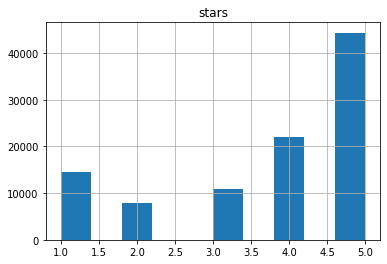

In [0]:
df.hist("stars")

In [0]:
df["stars"].value_counts()

5    44367
4    22103
1    14585
3    10970
2     7975
Name: stars, dtype: int64

**c) train_est split**

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['stars'], test_size=0.33, random_state=42)

In [0]:
df_test = pd.DataFrame(X_test)

**II) Rating prediction**

My objective was to use BERT in this section but I was not able to make a runnable code. Thus I decided to use TextBlob to have the possibility to get results.





**a) Predict sentiment polarity**

In [0]:
from textblob import TextBlob

In [0]:
def blobber(text):
  y = TextBlob(text).sentiment.polarity
  return y

In [0]:
from tqdm import tqdm
tqdm.pandas()

In [0]:
df_test['pred_polarity'] = df['text'].progress_map(blobber)

100%|██████████| 100000/100000 [02:02<00:00, 815.51it/s]


**b) Convert polarity into predicted number of stars**

To get the predicted rating from the predicted polarity, my idea is to evaluate the proportion of elements in each class. We will use X_train to get this information.

In [0]:
value_counts = list(y_train.value_counts().sort_index())

In [0]:
cumul_sums = list()
sum = 0
cumul_sums.append(0)
for x in value_counts:
  sum += x
  cumul_sums.append(sum)

In [0]:
cumul_q = [x/cumul_sums[-1] for x in cumul_sums]

In [0]:
cumul_q

[0.0,
 0.14613432835820894,
 0.22582089552238807,
 0.33586567164179104,
 0.5568358208955224,
 1.0]

In [0]:
y_pred = pd.qcut(df_test['pred_polarity'],q=cumul_q, labels=[1, 2, 3, 4, 5] )

**III) Analysing results in a quantative way**

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(y_test, y_pred)

0.48448484848484846

The global accuracy score is quite satisfaying because the number of classes is 5, which is quite a lot. Let's compute a confusion matrix to study these results in a more precise way.

In [0]:
ct = pd.crosstab(y_test, y_pred)

In [0]:
ct

pred_polarity,1,2,3,4,5
stars,,,,,
1,2814,816,604,379,181
2,904,521,514,471,226
3,448,461,688,1129,871
4,283,406,884,2172,3553
5,374,425,943,3140,9793


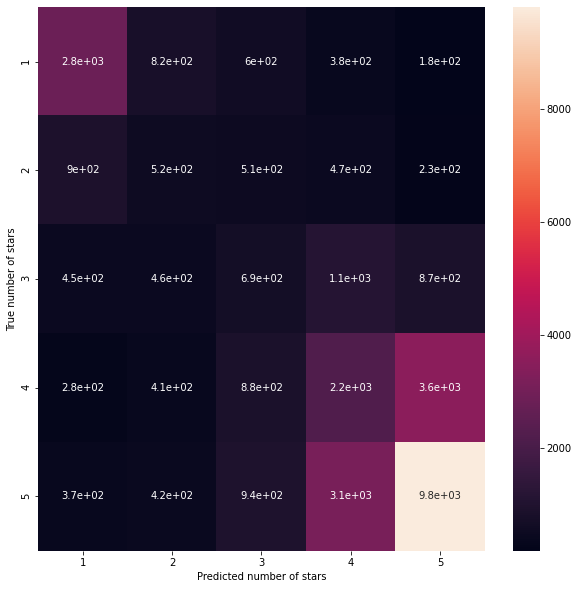

In [0]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(ct, [1, 2, 3, 4, 5], [1, 2, 3, 4, 5])
plt.figure(figsize=(10,10))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True number of stars')
plt.xlabel('Predicted number of stars')
plt.show()

This graph shows that the predictions are better in the extreme number of stars (1 and 5). I think this problem is intuitive, it is harder for the algorithm to predict classes between 2, 3 or 4 stars.

**IV) Wordclouds for qualitative analysis**

**a) Selecting data for Wordclouds**

In [0]:
df_merged = df_test.merge(y_pred.to_frame(name='pred_stars'), left_index=True, right_index=True)

In [0]:
df_merged = df_merged.merge(y_test.to_frame(name='nb_stars'), left_index=True, right_index=True)

In [0]:
df_merged['valid_prediction'] = df_merged.apply(lambda x : 1 if x['pred_stars'] == x['nb_stars'] else 0, axis=1)

In [0]:
df_merged['text'] = df_merged['text'].map(lambda x: x.lower())

In [0]:
df_true_ones = df

In [0]:
df_ones_good_predicted = df_merged.loc[(df_merged['nb_stars']==1) & (df_merged['valid_prediction'] ==1) ].iloc[:1000,:]
df_ones_bad_predicted = df_merged.loc[(df_merged['nb_stars']==1) & (df_merged['valid_prediction'] ==0) ].iloc[:1000,:]
df_fives_good_predicted = df_merged.loc[(df_merged['nb_stars']==5) & (df_merged['valid_prediction'] ==1) ].iloc[:1000,:]
df_fives_bad_predicted = df_merged.loc[(df_merged['nb_stars']==5) & (df_merged['valid_prediction'] ==0) ].iloc[:1000,:]

**b) Text Preprocessing**

In [0]:
import spacy
import en_core_web_sm

In [0]:
nlp = en_core_web_sm.load()

In [0]:
with open("/content/list_stop_words.txt", "r", encoding='utf-8') as f:
    list_stop_words = f.read().split('\n')

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

In [0]:
def get_tokens(df):

  rawText = ' '.join(df['text'].astype('str'))
  # Tokenization
  doc = nlp(rawText)
  text_content = list()

  for token in doc:
    # Removing punctuation dans stop words
    if (token.is_punct is False) and (token.lemma_ not in list_stop_words):
      # Taking only adjective to characterize Wordclouds
      if token.pos_ == 'ADJ':
        text_content.append(token.lemma_)

  return text_content

**c) Wordcloud Function**

In [0]:
def get_wordcloud(text_content):
  fdist = nltk.FreqDist(text_content)
  word_dict = {}
  for key in fdist:
      word_dict[key] = fdist[key]
  wordCloud = WordCloud(max_words=100, height=600, width=800, background_color="white", colormap='inferno')
  wordCloud.generate_from_frequencies(word_dict)
  return wordCloud

In [0]:
def show_wordcloud(df):
  text_content = get_tokens(df)
  wordCloud = get_wordcloud(text_content)
  fig = plt.figure(figsize=(12,16))
  plt.imshow(wordCloud, interpolation='bilinear')
  plt.show()

**d) Ploting Wordclouds**

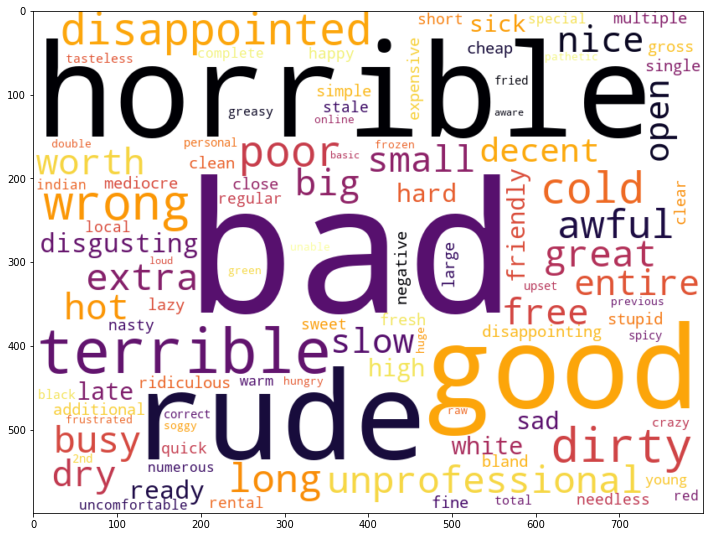

In [0]:
show_wordcloud(df_ones_good_predicted)

Clearly negative adjective. Easy to predict as 1 star review.

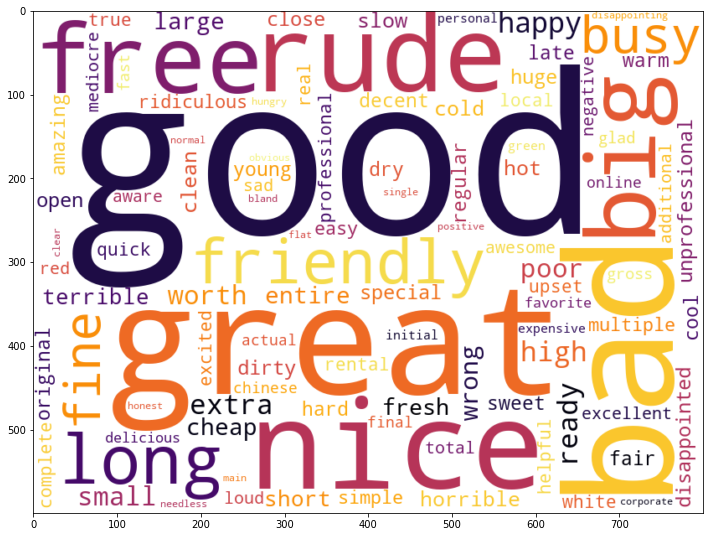

In [0]:
show_wordcloud(df_ones_bad_predicted)

The are many positive adjectives in this one-star reviews, which made the prediction harder (good, great, nice...).


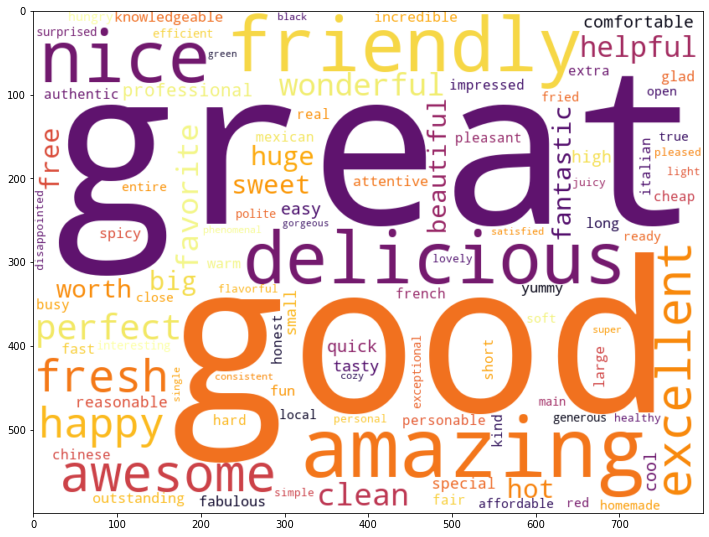

In [0]:
show_wordcloud(df_fives_good_predicted)

As before, this wordcloud from 5 stars reviews shows extremely positive adjectives.

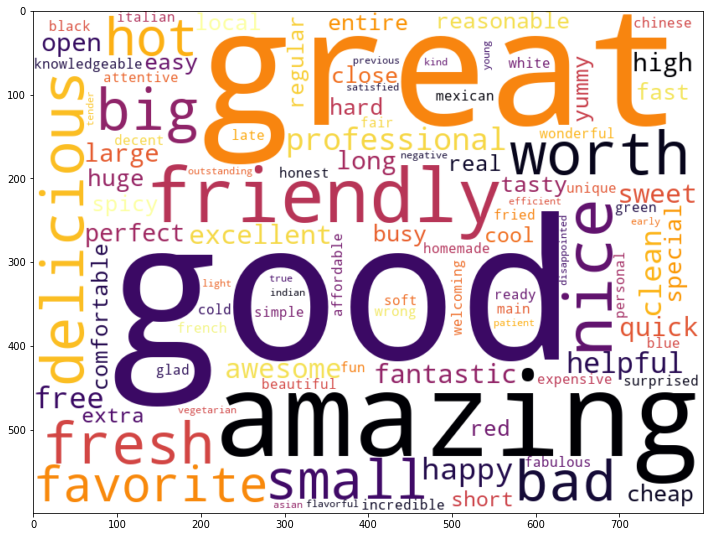

In [0]:
show_wordcloud(df_fives_bad_predicted)